In [20]:

import matplotlib.pyplot as plt
import numpy as np
import os
import joblib


import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

from sklearn.ensemble import  AdaBoostClassifier,GradientBoostingClassifier

from lightgbm import LGBMClassifier
from xgboost.sklearn import XGBClassifier
from catboost import CatBoostClassifier


from utils.load_data import load_data_train, load_data_test
from sklearn.metrics import confusion_matrix, accuracy_score,f1_score,recall_score,balanced_accuracy_score,classification_report,ConfusionMatrixDisplay

In [2]:
X_train,y_train = load_data_train()
X_test,y_test = load_data_test()

In [ ]:

# create a list of base models
base_models = [
    ("catboost", CatBoostClassifier()),
    ("lgbm", LGBMClassifier()),
    ("gbm", GradientBoostingClassifier()),
    ("xgb", XGBClassifier())
]

# create an AdaBoostClassifier and specify the base models
boosting = AdaBoostClassifier(base_estimator=None, n_estimators=3, random_state=42)

# fit the boosting classifier on the dataset
boosting.fit(X_train, y_train)


In [13]:

models_folder = "trained_models"
subset_folder = f"{models_folder}/boosting_base_clf"
# get the list of models in the subset folder
model_files = [f for f in os.listdir(subset_folder) if f.endswith('.joblib')]

loaded_models = [joblib.load(f"{subset_folder}/{f}") for f in model_files]

boost_predictions = []
for model in loaded_models:

    boost_clf = AdaBoostClassifier(n_estimators=4, estimator=model)
    boost_clf.fit(X_train, y_train)
    joblib.dump("AB_fin.joblib")
    y_pred = boost_clf.predict(X_test)
    # Append the predictions to the list
    boost_predictions.append(y_pred)

# Average the predictions to obtain the final prediction
boost_prediction = np.mean(boost_predictions, axis=0)



[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval


In [14]:
np.unique(boost_prediction)

array([0.  , 0.25, 0.5 , 0.75])

In [15]:
boost_pred = np.where(boost_prediction > 0.5, 1, 0)

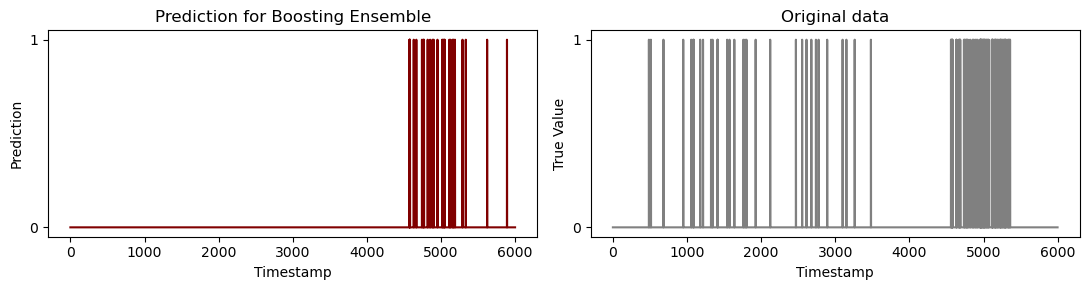

<Figure size 1100x300 with 0 Axes>

In [17]:

fig = plt.figure()
plt.rcParams["figure.figsize"] = (11,3)

# First plot
plt.subplot(1,2,1)
plt.title("Prediction for Boosting Ensemble")
plt.plot(np.arange(len(boost_pred[30000:36000])),boost_pred[30000:36000],color="maroon")
plt.xlabel("Timestamp")
plt.ylabel("Prediction")
plt.yticks([0.0, 1.0])

# Second plot
plt.subplot(1,2,2)
plt.title("Original data")
plt.plot(np.arange(len(y_test[30000:36000])),y_test[30000:36000],color="grey")
plt.xlabel("Timestamp")
plt.ylabel("True Value")
plt.yticks([0.0, 1.0])

plt.tight_layout()
plt.show()
plt.savefig('Boosting_ensemble.png')

In [18]:
base_model_weights = boost_clf.estimator_weights_

# Print the weights
for i, weight in enumerate(base_model_weights):
    print(f"Base model {i+1} weight: {weight}")

Base model 1 weight: 1.0
Base model 2 weight: 1.0
Base model 3 weight: 1.0
Base model 4 weight: 1.0


<Figure size 1100x300 with 0 Axes>

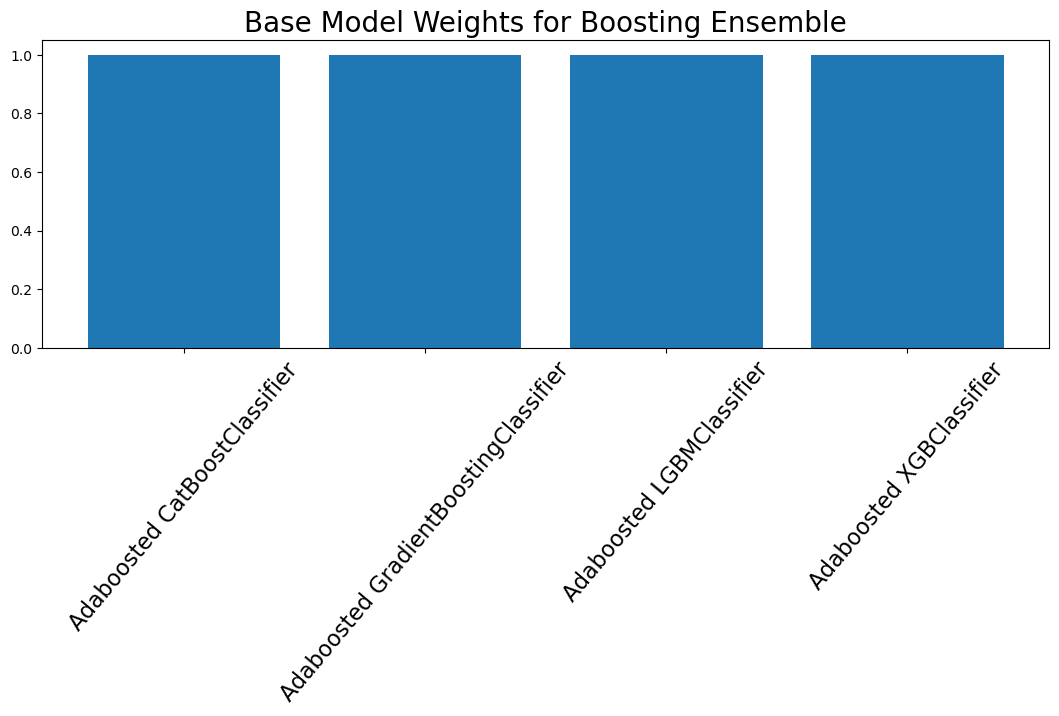

In [19]:
# base_models = clf.estimators_
weights = boost_clf.estimator_weights_

# Define the folder where the base models are saved
models_folder = "trained_models"
subset_folder = f"{models_folder}/boosting_base_clf"

# Get the list of file names in the folder
file_names = os.listdir(subset_folder)

# Extract the names of the models from the file names
base_model_names = [os.path.splitext(file_name)[0] for file_name in file_names]

fig = plt.figure()
plt.rcParams["figure.figsize"] = (13,4)
# Plot the weights of the base models
fig, ax = plt.subplots()
ax.bar(range(len(weights)), weights)
ax.set_xticks(range(len(base_model_names)))
boosted_model_names = ["Adaboosted " + name for name in base_model_names]
ax.set_xticklabels(boosted_model_names, rotation=50,fontsize =16)
ax.set_title(("Base Model Weights for Boosting Ensemble"),fontsize=20)
plt.show()


84.0


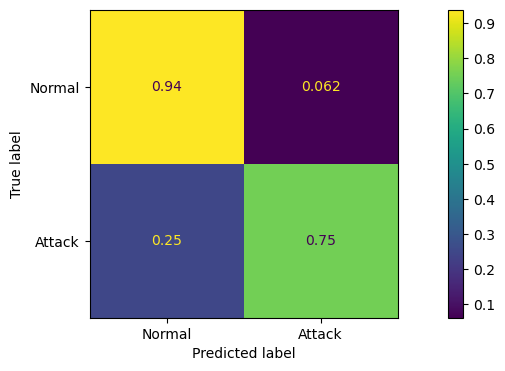

In [21]:
model_cm =confusion_matrix(y_test, boost_pred,normalize='true')

y_acc = accuracy_score(y_test, boost_pred)
y_f1score = f1_score(y_test, boost_pred)
y_recall = recall_score(y_test, boost_pred)
y_bal = balanced_accuracy_score(y_test, boost_pred)
print(round(balanced_accuracy_score(y_test, boost_pred),2)*100)

disp = ConfusionMatrixDisplay(confusion_matrix=model_cm, display_labels = ["Normal","Attack"])
disp.plot()


In [22]:
print(classification_report(y_test, boost_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94   1560065
         1.0       0.74      0.75      0.74    363663

    accuracy                           0.90   1923728
   macro avg       0.84      0.84      0.84   1923728
weighted avg       0.90      0.90      0.90   1923728

